In [1]:
from libdatasets import *
import librun
import libstop
from importlib import reload
from libadversarial import uncertainty_stop
from libstop import rank_stop_conds
from dotenv import load_dotenv; load_dotenv();
import matplotlib.pyplot as plt

## SVM

In [66]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("rcv1", wrap(rcv1, None)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear",
        #"random-forest"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [67]:
reload(librun)
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=9)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-a7676e9c-8dcb-4a41-9daf-d4bb0dce12fa.json']


Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

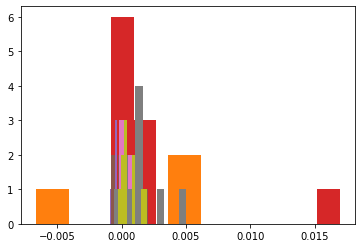

In [54]:
for config, _results in results_plots:
    plt.hist([np.diff(result.accuracy_score, 1)[-1] for result in _results])

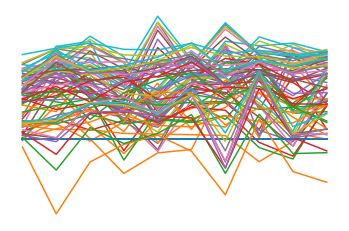

In [12]:
#fig = plt.figure(figsize=(1920/92,1080/92), dpi=92)
for config, _results in results_plots:
    plt.plot([result.accuracy_score.iloc[:10]-result.accuracy_score.iloc[0] for result in _results])
    #plt.ylim((-0.4, 0.4))
    plt.axis('off')
#fig.tight_layout()
#plt.savefig('lines_wallpaper.png', transparent=False, facecolor="w")

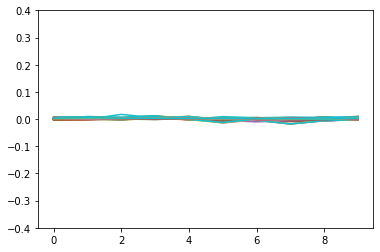

In [62]:
for config, _results in results_plots:
    plt.plot([result.accuracy_score[-10:]-result.accuracy_score.iloc[-10] for result in _results])
    plt.ylim((-0.4,0.4))

### Passive

In [13]:
from passive import run_passive

In [68]:
passive_results = run_passive(matrix['datasets'], range(10), 'svm-linear')

rcv1
Have results for rcv1
webkb
Have results for webkb
spamassassin
Have results for spamassassin
avila
Have results for avila
smartphone
Have results for smartphone
swarm
Have results for swarm
sensorless
Have results for sensorless
splice
Have results for splice
anuran
Have results for anuran


In [69]:
import libdatasets
def lmbda():
    yield ["Dataset", "1k accuracy", "Average gain", "Gain standard Error", "Instances", "Gain per 1000"]
    for config, _results in results_plots:
        p = passive_results[config.dataset_name]
        diffs = []
        onek = []
        for i, run in enumerate(config.runs):
            onek.append([_results[i].accuracy_score.iloc[-1]])
            diffs.append(p[run][0]-_results[i].accuracy_score.iloc[-1])
            #print("  ",run,  diffs[-1])
            
        X,y = getattr(libdatasets, config.dataset_name)(None)
        
        yield [config.dataset_name, np.mean(onek), np.mean(diffs), np.sqrt(np.var(diffs)), int(X.shape[0]/2-1000), 1000*np.mean(diffs)/(X.shape[0]/2)]
data = list(lmbda())

In [70]:
from tabulate import tabulate
print(tabulate(data[1:], headers=data[0], floatfmt=".1%", tablefmt="fancy_grid"))

╒══════════════╤═══════════════╤════════════════╤═══════════════════════╤═════════════╤═════════════════╕
│ Dataset      │   1k accuracy │   Average gain │   Gain standard Error │   Instances │   Gain per 1000 │
╞══════════════╪═══════════════╪════════════════╪═══════════════════════╪═════════════╪═════════════════╡
│ rcv1         │         90.2% │           5.0% │                  0.3% │      401207 │            0.0% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ webkb        │         87.4% │           1.9% │                  1.1% │        1099 │            0.9% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ spamassassin │         97.3% │           1.1% │                  0.2% │        2025 │            0.4% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ avila        │         56.5% │          -0.9

## Random forest

In [56]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("rcv1", wrap(rcv1, None)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        #"svm-linear",
        "random-forest"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [62]:
reload(librun)
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=9)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-a7676e9c-8dcb-4a41-9daf-d4bb0dce12fa.json']


Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

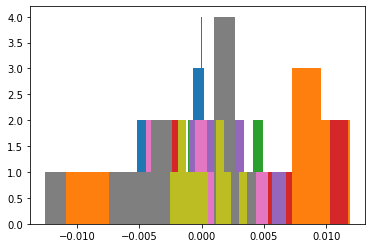

In [65]:
for config, _results in results_plots:
    plt.hist([np.diff(result.accuracy_score, 1)[-1] for result in _results])

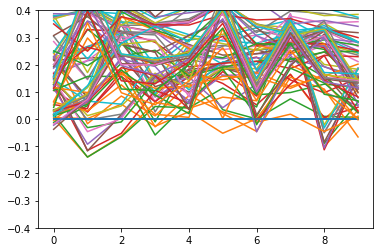

In [66]:
for config, _results in results_plots:
    plt.plot([result.accuracy_score.iloc[:10]-result.accuracy_score.iloc[0] for result in _results])
    plt.ylim((-0.4, 0.4))

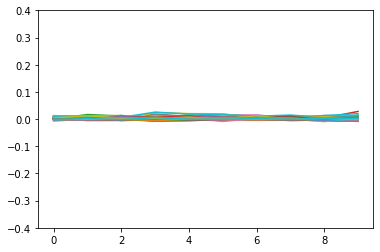

In [67]:
for config, _results in results_plots:
    plt.plot([result.accuracy_score[-10:]-result.accuracy_score.iloc[-10] for result in _results])
    plt.ylim((-0.4,0.4))

### Passive

In [13]:
from passive import run_passive

In [58]:
passive_results = run_passive(matrix['datasets'], range(10), 'random-forest')

rcv1
Have results for rcv1
webkb
Have results for webkb
spamassassin
Have results for spamassassin
avila
Have results for avila
smartphone
Have results for smartphone
swarm
Have results for swarm
sensorless
Have results for sensorless
splice
Have results for splice
anuran
Have results for anuran


In [64]:
import libdatasets
def lmbda():
    yield ["Dataset", "1k accuracy", "Average gain", "Gain standard Error", "Instances", "Gain per 1000"]
    for config, _results in results_plots:
        p = passive_results[config.dataset_name]
        diffs = []
        onek = []
        for i, run in enumerate(config.runs):
            onek.append([_results[i].accuracy_score.iloc[-1]])
            diffs.append(p[run][0]-_results[i].accuracy_score.iloc[-1])
            #print("  ",run,  diffs[-1])
            
        X,y = getattr(libdatasets, config.dataset_name)(None)
        
        yield [config.dataset_name, np.mean(onek), np.mean(diffs), np.sqrt(np.var(diffs)), int(X.shape[0]/2-1000), 1000*np.mean(diffs)/(X.shape[0]/2)]
data = list(lmbda())

In [65]:
from tabulate import tabulate
print(tabulate(data[1:], headers=data[0], floatfmt=".1%", tablefmt="fancy_grid"))

╒══════════════╤═══════════════╤════════════════╤═══════════════════════╤═════════════╤═════════════════╕
│ Dataset      │   1k accuracy │   Average gain │   Gain standard Error │   Instances │   Gain per 1000 │
╞══════════════╪═══════════════╪════════════════╪═══════════════════════╪═════════════╪═════════════════╡
│ rcv1         │         87.6% │           7.3% │                  0.7% │      401207 │            0.0% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ webkb        │         85.7% │           3.1% │                  0.9% │        1099 │            1.5% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ spamassassin │         96.2% │           1.1% │                  0.3% │        2025 │            0.4% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ avila        │         77.6% │          20.9

## Neural Net

In [71]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("rcv1", wrap(rcv1, None)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        #"svm-linear",
        "neural-network"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [74]:
import libutil; reload(libutil); reload(librun)
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=9)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-a7676e9c-8dcb-4a41-9daf-d4bb0dce12fa.json']


Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

Exception: Cache file '/home/zac/out/webkb__none__uncertainty__neural-network__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=len1000__pool_subsample=1000.csv' not found

In [13]:
from passive import run_passive

In [58]:
passive_results = run_passive(matrix['datasets'], range(10), 'neural-network')

rcv1
Have results for rcv1
webkb
Have results for webkb
spamassassin
Have results for spamassassin
avila
Have results for avila
smartphone
Have results for smartphone
swarm
Have results for swarm
sensorless
Have results for sensorless
splice
Have results for splice
anuran
Have results for anuran


In [64]:
import libdatasets
def lmbda():
    yield ["Dataset", "1k accuracy", "Average gain", "Gain standard Error", "Instances", "Gain per 1000"]
    for config, _results in results_plots:
        p = passive_results[config.dataset_name]
        diffs = []
        onek = []
        for i, run in enumerate(config.runs):
            onek.append([_results[i].accuracy_score.iloc[-1]])
            diffs.append(p[run][0]-_results[i].accuracy_score.iloc[-1])
            #print("  ",run,  diffs[-1])
            
        X,y = getattr(libdatasets, config.dataset_name)(None)
        
        yield [config.dataset_name, np.mean(onek), np.mean(diffs), np.sqrt(np.var(diffs)), int(X.shape[0]/2-1000), 1000*np.mean(diffs)/(X.shape[0]/2)]
data = list(lmbda())

In [65]:
from tabulate import tabulate
print(tabulate(data[1:], headers=data[0], floatfmt=".1%", tablefmt="fancy_grid"))

╒══════════════╤═══════════════╤════════════════╤═══════════════════════╤═════════════╤═════════════════╕
│ Dataset      │   1k accuracy │   Average gain │   Gain standard Error │   Instances │   Gain per 1000 │
╞══════════════╪═══════════════╪════════════════╪═══════════════════════╪═════════════╪═════════════════╡
│ rcv1         │         87.6% │           7.3% │                  0.7% │      401207 │            0.0% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ webkb        │         85.7% │           3.1% │                  0.9% │        1099 │            1.5% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ spamassassin │         96.2% │           1.1% │                  0.3% │        2025 │            0.4% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ avila        │         77.6% │          20.9